# Cle Elum Ridge (CER) xDEM

### Notebook contents 
* using xDEM to create variograms

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster_xdem**
* Created new env: clone of *raster* from Linux box, called *raster_xdem* for the xdem package

In [1]:
# import packages 
# %matplotlib widget
# %matplotlib inline #have to remote this to get rid of the scikit-gstat warning with plotting... 

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots # adding for subplots
import plotly.figure_factory as ff

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
# import rasterstats

In [2]:
# sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

In [3]:
!conda env list

# conda environments:
#
                         /home/lumbraca/mambaforge/envs/raster
                      *  /home/lumbraca/mambaforge/envs/raster_xdem
base                     /opt/miniconda3
python                   /opt/miniconda3/envs/python



In [4]:
# labels and cosntants 
# titles
cer_title = 'CER Small Domain'

# labels 
dce_label = 'distance to canopy edge (m)'
dah_label = 'diurnal anisotropic heat index'
slope_label = 'slope (degrees)'
aspect_label = 'aspect (degrees)'
snow_label = 'snow depth (m)'

dceclassdict = {1: 'Large Clusters', 2: 'Small Clusters', 3: 'Edges', 4: 'Small Gaps', 5: 'Large Gaps'}

In [5]:
ds = xr.open_dataset('/home/lumbraca/raster/data/cer_smalldomain_create_netcdf.nc')
# ds

### Proper reclassification groups

|group|name|DCE range|
|-|-|--:|
|group 1:|Large Gaps|3 <  DCE <=  8|
|group 2:|Small Gaps|1 <  DCE <=  3|
|group 3:|Edges|-1 <= DCE <=  1
|group 4:|Small Clusters|-3 <= DCE <= -1|
|group 5:|Large Clusters|      DCE <  -3|

In [6]:
# flatten everything to save time later
dce_flat=ds.dce.values.flatten()
dce_reclass_flat=ds.dce_reclass.values.flatten()

dce_giulia_flat=ds.dce_giulia.values.flatten()
dce_giulia_reclass_flat=ds.dce_giulia_reclass.values.flatten()

dah_flat=ds.dah.values.flatten()
dah_reclass_flat=ds.dah_reclass.values.flatten()

snowdepth_flat=ds.snowdepth.values.flatten()
slope_flat=ds.slope.values.flatten()
aspect_flat=ds.aspect.values.flatten()

dce_dahpos_reclass_flat=ds.dce_dahpos_reclass.values.flatten()
dce_dahneg_reclass_flat=ds.dce_dahneg_reclass.values.flatten()

In [7]:
# Make groups for dce classifications
# setting to larger values outside of distance ranges to avoid overwriting 
largeclusters = ds.where(ds.dce_reclass == 100)
smallclusters = ds.where(ds.dce_reclass == 200)
canopyedges   = ds.where(ds.dce_reclass == 300)
smallgaps     = ds.where(ds.dce_reclass == 400)
largegaps     = ds.where(ds.dce_reclass == 500)

# Make groups for dah classification 
dahpos = ds.where(ds.dce_reclass ==  1)
dahneg = ds.where(ds.dce_reclass == -1)

# Flatten and remove nans -----------------------------------------------------------------------
# dce
largeclusters_flat = largeclusters.snowdepth.values.flatten()
smallclusters_flat = smallclusters.snowdepth.values.flatten()
canopyedges_flat   = canopyedges.snowdepth.values.flatten()
smallgaps_flat     = smallgaps.snowdepth.values.flatten()
largegaps_flat     = largegaps.snowdepth.values.flatten()

largeclusters_flat = largeclusters_flat[~(np.isnan(largeclusters_flat))] # removing the nans 
smallclusters_flat = smallclusters_flat[~(np.isnan(smallclusters_flat))]
canopyedges_flat   = canopyedges_flat[~(np.isnan(canopyedges_flat))]
smallgaps_flat     = smallgaps_flat[~(np.isnan(smallgaps_flat))]
largegaps_flat     = largegaps_flat[~(np.isnan(largegaps_flat))]

# dah
dahpos_flat     = dahpos.snowdepth.values.flatten()
dahpos_flat     = dahpos_flat[~(np.isnan(dahpos_flat))]

dahneg_flat     = dahneg.snowdepth.values.flatten()
dahneg_flat     = dahneg_flat[~(np.isnan(dahneg_flat))]



# For pos vs neg groups -----------------------------------------------------------------------
# first set the values for each of the two pos and neg datasets 
largeclusters_dahpos = ds.where(ds.dce_dahpos_reclass == 100)
smallclusters_dahpos = ds.where(ds.dce_dahpos_reclass == 200)
canopyedges_dahpos   = ds.where(ds.dce_dahpos_reclass == 300)
smallgaps_dahpos     = ds.where(ds.dce_dahpos_reclass == 400)
largegaps_dahpos     = ds.where(ds.dce_dahpos_reclass == 500)

largeclusters_dahneg = ds.where(ds.dce_dahneg_reclass == 100)
smallclusters_dahneg = ds.where(ds.dce_dahneg_reclass == 200)
canopyedges_dahneg   = ds.where(ds.dce_dahneg_reclass == 300)
smallgaps_dahneg     = ds.where(ds.dce_dahneg_reclass == 400)
largegaps_dahneg     = ds.where(ds.dce_dahneg_reclass == 500)


# For pos vs neg groups 
# dce pos dah
largeclusters_dahpos_flat = largeclusters_dahpos.snowdepth.values.flatten()
smallclusters_dahpos_flat = smallclusters_dahpos.snowdepth.values.flatten()
canopyedges_dahpos_flat   = canopyedges_dahpos.snowdepth.values.flatten()
smallgaps_dahpos_flat     = smallgaps_dahpos.snowdepth.values.flatten()
largegaps_dahpos_flat     = largegaps_dahpos.snowdepth.values.flatten()

largeclusters_dahpos_flat = largeclusters_dahpos_flat[~(np.isnan(largeclusters_dahpos_flat))] # removing the nans 
smallclusters_dahpos_flat = smallclusters_dahpos_flat[~(np.isnan(smallclusters_dahpos_flat))]
canopyedges_dahpos_flat   = canopyedges_dahpos_flat[~(np.isnan(canopyedges_dahpos_flat))]
smallgaps_dahpos_flat     = smallgaps_dahpos_flat[~(np.isnan(smallgaps_dahpos_flat))]
largegaps_dahpos_flat     = largegaps_dahpos_flat[~(np.isnan(largegaps_dahpos_flat))]

# dce neg dah
largeclusters_dahneg_flat = largeclusters_dahneg.snowdepth.values.flatten()
smallclusters_dahneg_flat = smallclusters_dahneg.snowdepth.values.flatten()
canopyedges_dahneg_flat   = canopyedges_dahneg.snowdepth.values.flatten()
smallgaps_dahneg_flat     = smallgaps_dahneg.snowdepth.values.flatten()
largegaps_dahneg_flat     = largegaps_dahneg.snowdepth.values.flatten()

largeclusters_dahneg_flat = largeclusters_dahneg_flat[~(np.isnan(largeclusters_dahneg_flat))] # removing the nans 
smallclusters_dahneg_flat = smallclusters_dahneg_flat[~(np.isnan(smallclusters_dahneg_flat))]
canopyedges_dahneg_flat   = canopyedges_dahneg_flat[~(np.isnan(canopyedges_dahneg_flat))]
smallgaps_dahneg_flat     = smallgaps_dahneg_flat[~(np.isnan(smallgaps_dahneg_flat))]
largegaps_dahneg_flat     = largegaps_dahneg_flat[~(np.isnan(largegaps_dahneg_flat))]

## Box and Violin Plots

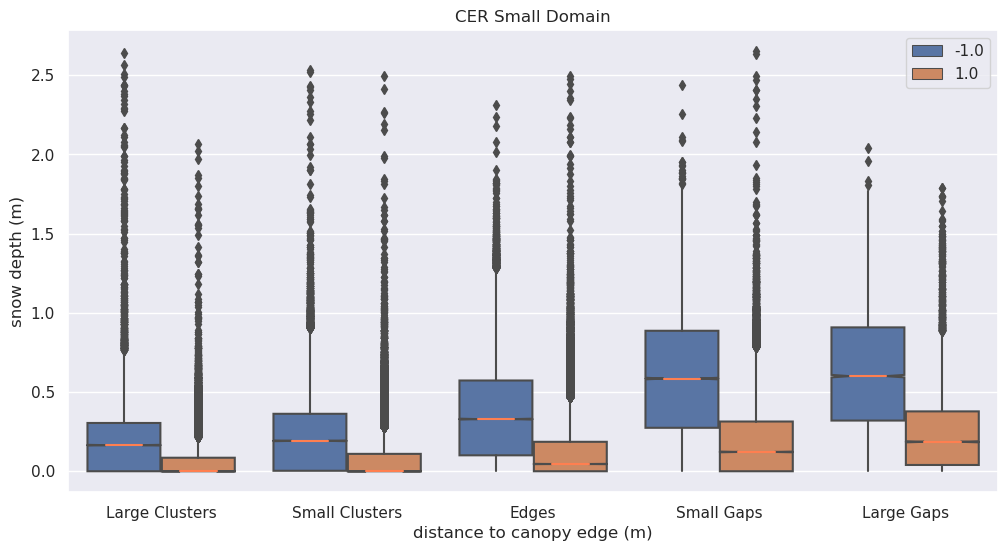

In [8]:
plt.figure(figsize=(12,6))

sns.boxplot(x=dce_reclass_flat, y=snowdepth_flat, hue=dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
plt.xlabel(dce_label)
plt.ylabel(snow_label)
plt.title('CER Small Domain')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])

plt.show()

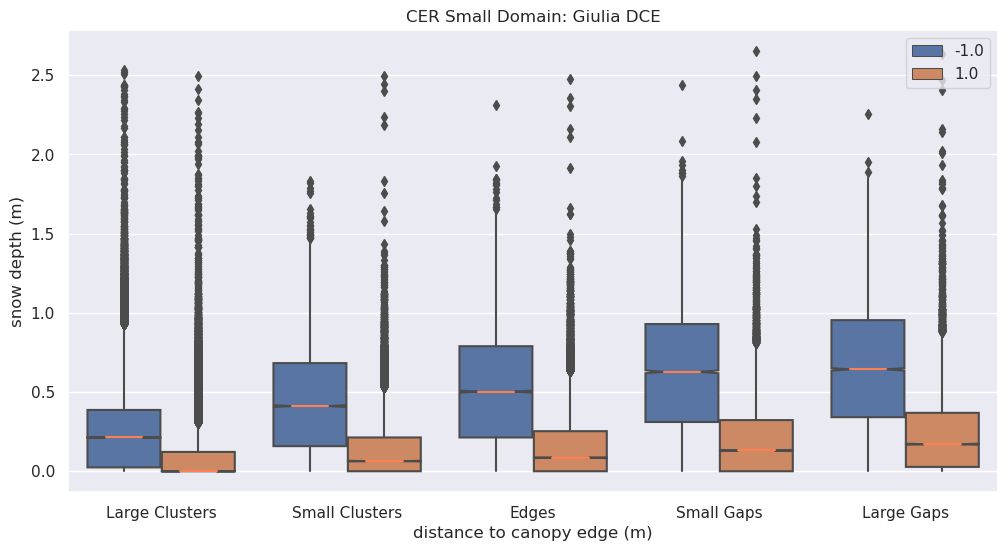

In [9]:
plt.figure(figsize=(12,6))

f = sns.boxplot(x=dce_giulia_reclass_flat, y=snowdepth_flat, hue=dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
plt.xlabel(dce_label)
plt.ylabel(snow_label)
plt.title('CER Small Domain: Giulia DCE')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])
plt.legend(loc='upper right')

# plt.legend[{-1:'DAH < 0', 1:'DAH >0'}]
# plt.legend(['first', 'second', 'third', '4', '5', '6', '7', '8'], loc='upper right')

plt.show()

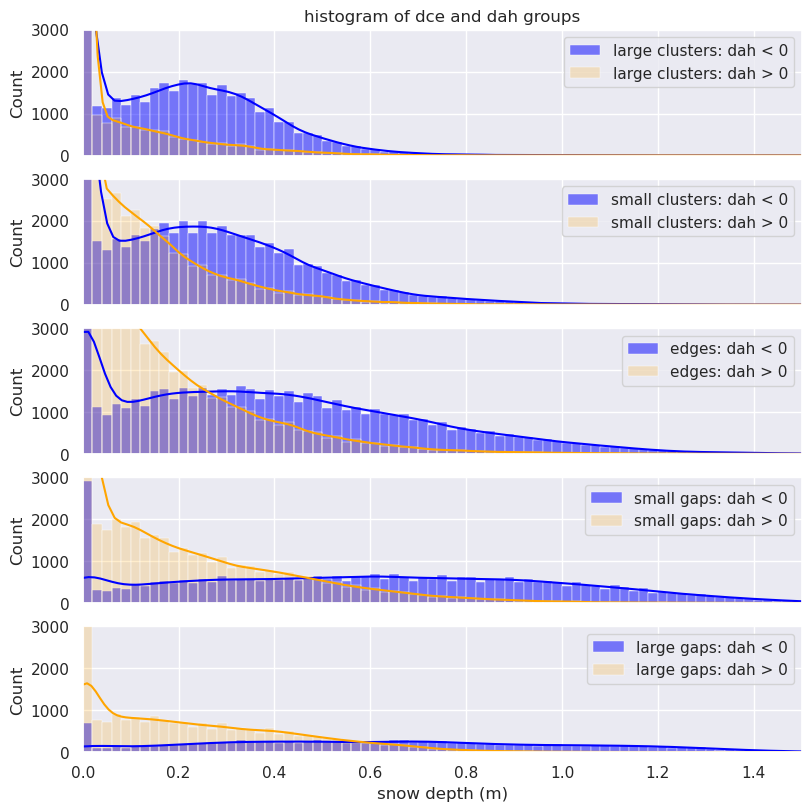

In [10]:
fig, axes = plt.subplots(5, 1, figsize=(8,8), sharex=True, sharey=True, constrained_layout = True) #gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2]}

alpha1 = 0.5
alpha2 = 0.2

binwidth = 0.02 # snow depth into bins (2 cm?)

sns.histplot(ax=axes[0], data=largeclusters_dahneg_flat, label='large clusters: dah < 0', color='blue', alpha=alpha1, binwidth=binwidth, kde=True)
sns.histplot(ax=axes[0], data=largeclusters_dahpos_flat, label='large clusters: dah > 0', color='orange', alpha=alpha2, binwidth=binwidth, kde=True)

sns.histplot(ax=axes[1], data=smallclusters_dahneg_flat, label='small clusters: dah < 0', color='blue', alpha=alpha1, binwidth=binwidth, kde=True)
sns.histplot(ax=axes[1], data=smallclusters_dahpos_flat, label='small clusters: dah > 0', color='orange', alpha=alpha2, binwidth=binwidth, kde=True)

sns.histplot(ax=axes[2], data=canopyedges_dahneg_flat,  label='edges: dah < 0', color='blue', alpha=alpha1, binwidth=binwidth, kde=True)
sns.histplot(ax=axes[2], data=canopyedges_dahpos_flat,  label='edges: dah > 0', color='orange', alpha=alpha2, binwidth=binwidth, kde=True)

sns.histplot(ax=axes[3], data=smallgaps_dahneg_flat,    label='small gaps: dah < 0', color='blue', alpha=alpha1, binwidth=binwidth, kde=True)
sns.histplot(ax=axes[3], data=smallgaps_dahpos_flat,    label='small gaps: dah > 0', color='orange', alpha=alpha2, binwidth=binwidth, kde=True)

sns.histplot(ax=axes[4], data=largegaps_dahneg_flat,    label='large gaps: dah < 0', color='blue', alpha=alpha1, binwidth=binwidth, kde=True)
sns.histplot(ax=axes[4], data=largegaps_dahpos_flat,    label='large gaps: dah > 0', color='orange', alpha=alpha2, binwidth=binwidth, kde=True)


axes[0].set_xlim([0,1.5])
axes[0].set_ylim([0,3000])

axes[4].set_xlabel('snow depth (m)')
axes[0].set_title('histogram of dce and dah groups')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
plt.show()

# xDEM

In [11]:
import xdem

/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/skgstat/models.py:22: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/skgstat/models.py:86: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/sk

In [12]:
ds

<xarray.Dataset>
Dimensions:                         (x: 736, y: 649, band: 1)
Coordinates:
  * x                               (x) float64 1.528e+06 1.528e+06 ... 1.53e+06
  * y                               (y) float64 6.914e+05 ... 6.894e+05
  * band                            (band) int32 1
Data variables: (12/32)
    snowdepth                       (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    dce                             (band, y, x) float32 1.293 0.9144 ... -4.572
    slope                           (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    aspect                          (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    dah                             (band, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    dce_giulia                      (band, y, x) float32 nan nan nan ... nan nan
    ...                              ...
    canopyedges_negdah_snowdepth    (band, y, x) float32 ...
    smallgaps_posdah_snowdepth      (band, y, x) float32 ...
    smallgaps_negdah_snowdepth      (band, y, x) float32 ...
    largegaps_posdah_snowdepth      (band, y, x) float32 ...
    largegaps_negdah_snowdepth      (band, y, x) float32 ...
    spatial_ref                     int32 ...

In [13]:
# # We want all the snow depth values.. for each dce group

# # Also saving these into the xarray dataframe, then else is nan for each group 
# ds['largeclusters_snowdepth'] = ds.snowdepth.where(ds.dce_reclass_2 == 100)
# ds['smallclusters_snowdepth'] = ds.snowdepth.where(ds.dce_reclass_2 == 200)
# ds['canopyedges_snowdepth']   = ds.snowdepth.where(ds.dce_reclass_2 == 300)
# ds['smallgaps_snowdepth']     = ds.snowdepth.where(ds.dce_reclass_2 == 400)
# ds['largegaps_snowdepth']     = ds.snowdepth.where(ds.dce_reclass_2 == 500)

# # And, we want (from those) where dah is positive or negative 
# ds['largeclusters_posdah_snowdepth'] = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass_2 == 100))
# ds['largeclusters_negdah_snowdepth'] = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass_2 == 100))

# ds['smallclusters_posdah_snowdepth'] = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass_2 == 200))
# ds['smallclusters_negdah_snowdepth'] = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass_2 == 200))

# ds['canopyedges_posdah_snowdepth']   = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass_2 == 300))
# ds['canopyedges_negdah_snowdepth']   = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass_2 == 300))

# ds['smallgaps_posdah_snowdepth']     = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass_2 == 400))
# ds['smallgaps_negdah_snowdepth']     = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass_2 == 400))

# ds['largegaps_posdah_snowdepth']     = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass_2 == 500))
# ds['largegaps_negdah_snowdepth']     = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass_2 == 500))

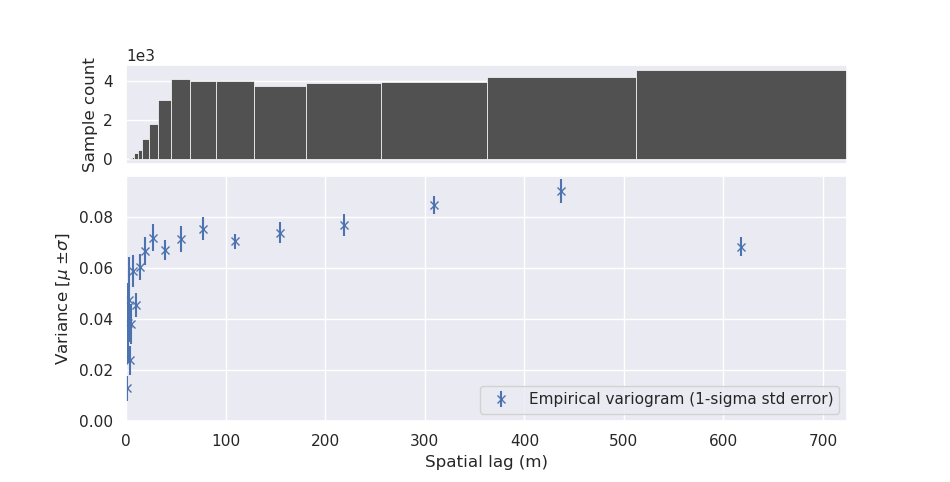

In [ ]:
# for all snow depths... just to see
var_snowdepth = xdem.spatialstats.sample_empirical_variogram(
    values=ds.snowdepth.to_numpy(), gsd=1, subsample=100, n_variograms=10, random_state=42
)

xdem.spatialstats.plot_variogram(var_snowdepth)

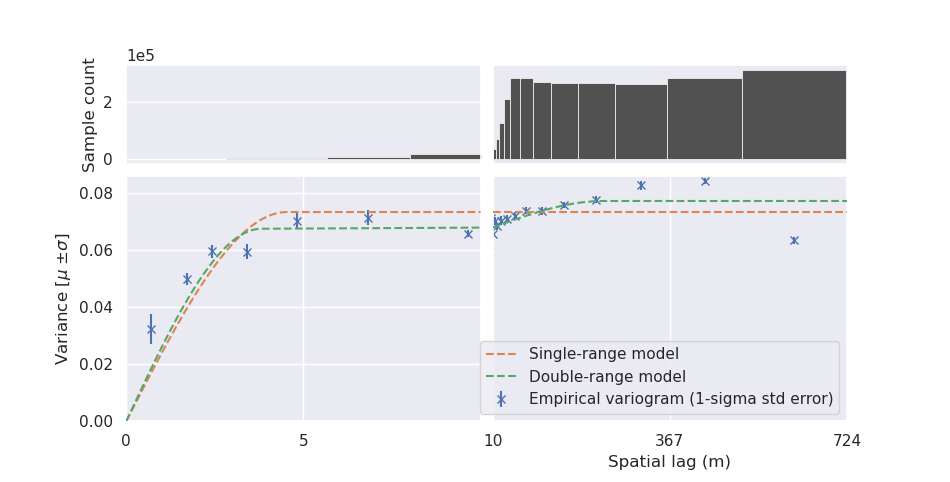

In [ ]:
# var_snowdepth = xdem.spatialstats.sample_empirical_variogram(
#     values=ds.snowdepth.to_numpy(), gsd=1, subsample=1000, n_variograms=10, random_state=42
# )

data = var_snowdepth

# Create the functions
func_sum_vgm1, params_vgm1 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical"], empirical_variogram=data
)

func_sum_vgm2, params_vgm2 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical", "Spherical"], empirical_variogram=data
)

# Plot
xdem.spatialstats.plot_variogram(
    data,
    list_fit_fun=[func_sum_vgm1, func_sum_vgm2],
    list_fit_fun_label=["Single-range model", "Double-range model"],
    xscale_range_split=[10],
)

## Resample using xDEM
https://geoutils.readthedocs.io/en/stable/raster_class.html#reproject

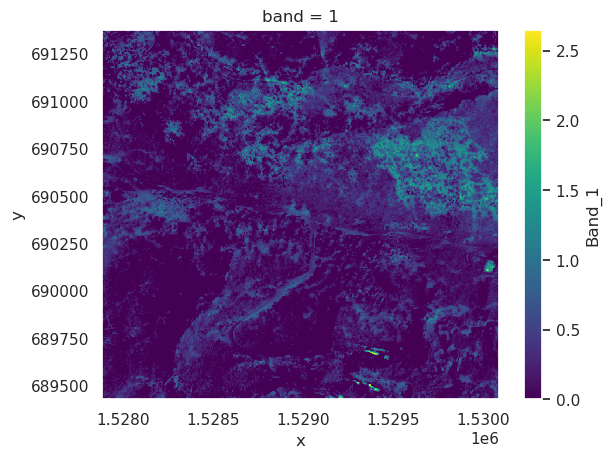

In [19]:
ds.snowdepth.plot()

# Other Old Stats Stuff

## Non-parametric test for difference in the means

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Kruskal-Wallis Test
* used to determine whether or not there is a statistically significant differences between the medians of three or more independent groups 
* is considered the non-parametric equivalent of One-Way ANOVA 
https://www.statology.org/kruskal-wallis-test-python/

In [ ]:
# trying Kruskal-Wallis Test, between only the dce groups
stats.kruskal(largeclusters_flat, smallclusters_flat, canopyedges_flat, smallgaps_flat, largegaps_flat)

KruskalResult(statistic=38200.12772889163, pvalue=0.0)

In [ ]:
# trying Kruskal-Wallis Test, between each dce group individually 
stats.kruskal(largeclusters_dahpos_flat, largeclusters_dahneg_flat) 
stats.kruskal(smallclusters_dahpos_flat, smallclusters_dahneg_flat) 
stats.kruskal(canopyedges_dahpos_flat, canopyedges_dahneg_flat) 
stats.kruskal(smallgaps_dahpos_flat, smallgaps_dahneg_flat) 
stats.kruskal(largegaps_dahpos_flat, largegaps_dahneg_flat) 

KruskalResult(statistic=10274.505201546732, pvalue=0.0)

In [ ]:
# trying Kruskal-Wallis Test, between all dah pos groups
stats.kruskal(largeclusters_dahpos_flat, smallclusters_dahpos_flat, canopyedges_dahpos_flat, smallgaps_dahpos_flat, largegaps_dahpos_flat)

KruskalResult(statistic=25108.023418095447, pvalue=0.0)

In [ ]:
# trying Kruskal-Wallis Test, between all dah neg groups
stats.kruskal(largeclusters_dahneg_flat, smallclusters_dahneg_flat, canopyedges_dahneg_flat, smallgaps_dahneg_flat, largegaps_dahneg_flat)

KruskalResult(statistic=42374.56839731968, pvalue=0.0)

### Non-parametric Multiple Comparisons Following the Kruskal-Wallis Test
* interested in which groups differ from others 
From the USGS Textbook Chapter 7 Page 209 

"A conceptually simple nonparametric MCT is evaluate group patterns following a Kruskal-Wallis test is to compute all possible pairwise Wilcoxon rank-sum tests, 

setting the tests' error rates to achieve the family error rate, $\alpha_{family}$"

In [ ]:
df_dah = pd.DataFrame(index=range(len(canopyedges_dahpos_flat)), columns=range(10))

df_dah[0].update(largeclusters_dahpos_flat)
df_dah[1].update(largeclusters_dahneg_flat)
df_dah[2].update(smallclusters_dahpos_flat)
df_dah[3].update(smallclusters_dahneg_flat)
df_dah[4].update(canopyedges_dahpos_flat)
df_dah[5].update(canopyedges_dahneg_flat)
df_dah[6].update(smallgaps_dahpos_flat)
df_dah[7].update(smallgaps_dahneg_flat)
df_dah[8].update(largegaps_dahpos_flat)
df_dah[9].update(largegaps_dahneg_flat)

In [ ]:
df_dah

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.063996,0.0,0.600447,0.0,0.777255
1,0.0,0.0,0.0,0.0,0.0,0.259035,0.0,0.646137,0.0,0.768102
2,0.0,0.0,0.0,0.0,0.0,0.48771,0.0,0.743694,0.0,0.734541
3,0.0,0.0,0.0,0.204192,0.0,0.03051,0.0,0.704106,0.0,0.649188
4,0.0,0.0,0.0,0.161553,0.0,0.042714,0.0,0.65529,0.0,0.646137
...,...,...,...,...,...,...,...,...,...,...
85717,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
85718,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
85719,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
85720,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# randomly sample from each group, 10,000

sample_size = 500

largeclusters_dahpos_sample = np.random.choice(largeclusters_dahpos_flat, sample_size)
smallclusters_dahpos_sample = np.random.choice(smallclusters_dahpos_flat, sample_size)
canopyedges_dahpos_sample   = np.random.choice(canopyedges_dahpos_flat, sample_size)
smallgaps_dahpos_sample     = np.random.choice(smallgaps_dahpos_flat, sample_size)
largegaps_dahpos_sample     = np.random.choice(largegaps_dahpos_flat, sample_size)

largeclusters_dahneg_sample = np.random.choice(largeclusters_dahneg_flat, sample_size)
smallclusters_dahneg_sample = np.random.choice(smallclusters_dahneg_flat, sample_size)
canopyedges_dahneg_sample   = np.random.choice(canopyedges_dahneg_flat, sample_size)
smallgaps_dahneg_sample     = np.random.choice(smallgaps_dahneg_flat, sample_size)
largegaps_dahneg_sample     = np.random.choice(largegaps_dahneg_flat, sample_size)

In [ ]:
# trying Wilcoxon Rank Sums Test between all possible groups 
# stats.wilcoxon(largeclusters_dahpos_flat, largeclusters_dahneg_flat)
# stats.wilcoxon(df_dah, nan_policy='omit')
# stats.wilcoxon(df_dah[0], df_dah[1], nan_policy='omit') # nan policy: propagate, omit, raise (error)

In [ ]:
stats.ranksums(largeclusters_dahpos_flat.mean(), largeclusters_dahneg_flat.mean())

RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)

In [ ]:
stats.ranksums(smallclusters_dahpos_flat.mean(), smallclusters_dahneg_flat.mean())

RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)

In [ ]:
stats.ranksums(smallgaps_dahpos_flat.mean(), smallgaps_dahneg_flat.mean())

RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)

### Mann-Whitney U Rank Test 
* trying to get around the issue of groups with different sizes

In [ ]:
# Mann Whitney U rank test on two independent samples 
# non-parametric test to determine is the underlying distrubution of sampel x is the same as y 
stats.mannwhitneyu(largeclusters_dahpos_flat, largeclusters_dahneg_flat)

MannwhitneyuResult(statistic=351348441.5, pvalue=0.0)

In [ ]:
# if each dce group is different to itself with dah neg or pos 
# s1, p1 = stats.mannwhitneyu(largeclusters_dahpos_flat, largeclusters_dahneg_flat) 
# s2, p2 = stats.mannwhitneyu(smallclusters_dahpos_flat, smallclusters_dahneg_flat) 
# s3, p3 = stats.mannwhitneyu(canopyedges_dahpos_flat, canopyedges_dahneg_flat) 
# s4, p4 = stats.mannwhitneyu(smallgaps_dahpos_flat, smallgaps_dahneg_flat) 
# s5, p5 = stats.mannwhitneyu(largegaps_dahpos_flat, largegaps_dahneg_flat) 

s1, p1 = stats.mannwhitneyu(largeclusters_dahpos_sample, largeclusters_dahneg_sample) 
s2, p2 = stats.mannwhitneyu(smallclusters_dahpos_sample, smallclusters_dahneg_sample) 
s3, p3 = stats.mannwhitneyu(canopyedges_dahpos_sample, canopyedges_dahneg_sample) 
s4, p4 = stats.mannwhitneyu(smallgaps_dahpos_sample, smallgaps_dahneg_sample) 
s5, p5 = stats.mannwhitneyu(largegaps_dahpos_sample, largegaps_dahneg_sample) 

print('P1', p1)
print('P2', p1)
print('P3', p1)
print('P4', p1)
print('P5', p1)

P1 3.3775569141157563e-46
P2 3.3775569141157563e-46
P3 3.3775569141157563e-46
P4 3.3775569141157563e-46
P5 3.3775569141157563e-46


In [ ]:
# Now, comparing only pos dah groups against all dce groups 
# For DAH pos
# for all data 
# s6, p6 = stats.mannwhitneyu(largeclusters_dahpos_flat, smallclusters_dahpos_flat) 
# s7, p7 = stats.mannwhitneyu(largeclusters_dahpos_flat, canopyedges_dahpos_flat) 
# s8, p8 = stats.mannwhitneyu(largeclusters_dahpos_flat, smallgaps_dahpos_flat) 
# s9, p9 = stats.mannwhitneyu(largeclusters_dahpos_flat, largegaps_dahpos_flat) 

# s10, p10 = stats.mannwhitneyu(smallclusters_dahpos_flat, canopyedges_dahpos_flat) 
# s11, p11 = stats.mannwhitneyu(smallclusters_dahpos_flat, smallgaps_dahpos_flat) 
# s12, p12 = stats.mannwhitneyu(smallclusters_dahpos_flat, largegaps_dahpos_flat) 

# s13, p13 = stats.mannwhitneyu(canopyedges_dahpos_flat, smallgaps_dahpos_flat) 
# s14, p14 = stats.mannwhitneyu(canopyedges_dahpos_flat, largegaps_dahpos_flat) 

# s15, p15 = stats.mannwhitneyu(smallgaps_dahpos_flat, largegaps_dahpos_flat) 

# random sample
s6, p6 = stats.mannwhitneyu(largeclusters_dahpos_sample, smallclusters_dahpos_sample) 
s7, p7 = stats.mannwhitneyu(largeclusters_dahpos_sample, canopyedges_dahpos_sample) 
s8, p8 = stats.mannwhitneyu(largeclusters_dahpos_sample, smallgaps_dahpos_sample) 
s9, p9 = stats.mannwhitneyu(largeclusters_dahpos_sample, largegaps_dahpos_sample) 

s10, p10 = stats.mannwhitneyu(smallclusters_dahpos_sample, canopyedges_dahpos_sample) 
s11, p11 = stats.mannwhitneyu(smallclusters_dahpos_sample, smallgaps_dahpos_sample) 
s12, p12 = stats.mannwhitneyu(smallclusters_dahpos_sample, largegaps_dahpos_sample) 

s13, p13 = stats.mannwhitneyu(canopyedges_dahpos_sample, smallgaps_dahpos_sample) 
s14, p14 = stats.mannwhitneyu(canopyedges_dahpos_sample, largegaps_dahpos_sample) 

s15, p15 = stats.mannwhitneyu(smallgaps_dahpos_sample, largegaps_dahpos_sample)

print('P6', p6)
print('P7', p7)
print('P8', p8)
print('P9', p9)
print('P10', p10)
print('P11', p11)
print('P12', p12)
print('P13', p13)
print('P14', p14)
print('P15', p15)

P6 0.10067022518487943
P7 1.9526739411202013e-09
P8 2.3725103308182767e-32
P9 6.103886820985893e-48
P10 6.272904570261848e-06
P11 4.8080346945579726e-26
P12 2.2946308296845756e-41
P13 1.4745969931667957e-09
P14 8.874744104186006e-20
P15 0.0013093909885362146


In [ ]:
# Now, comparing only neg nag groups against all dce groups 
# For DAH neg
# for all data 
# s16, p16 = stats.mannwhitneyu(largeclusters_dahneg_flat, smallclusters_dahneg_flat) 
# s17, p17 = stats.mannwhitneyu(largeclusters_dahneg_flat, canopyedges_dahneg_flat) 
# s18, p18 = stats.mannwhitneyu(largeclusters_dahneg_flat, smallgaps_dahneg_flat) 
# s19, p19 = stats.mannwhitneyu(largeclusters_dahneg_flat, largegaps_dahneg_flat) 

# s20, p20 = stats.mannwhitneyu(smallclusters_dahneg_flat, canopyedges_dahneg_flat) 
# s21, p21 = stats.mannwhitneyu(smallclusters_dahneg_flat, smallgaps_dahneg_flat) 
# s22, p22 = stats.mannwhitneyu(smallclusters_dahneg_flat, largegaps_dahneg_flat) 

# s23, p23 = stats.mannwhitneyu(canopyedges_dahneg_flat, smallgaps_dahneg_flat) 
# s24, p24 = stats.mannwhitneyu(canopyedges_dahneg_flat, largegaps_dahneg_flat) 

# s25, p25 = stats.mannwhitneyu(smallgaps_dahneg_flat, largegaps_dahneg_flat) 


# For DAH neg
# for a sample of the data
s16, p16 = stats.mannwhitneyu(largeclusters_dahneg_sample, smallclusters_dahneg_sample) 
s17, p17 = stats.mannwhitneyu(largeclusters_dahneg_sample, canopyedges_dahneg_sample) 
s18, p18 = stats.mannwhitneyu(largeclusters_dahneg_sample, smallgaps_dahneg_sample) 
s19, p19 = stats.mannwhitneyu(largeclusters_dahneg_sample, largegaps_dahneg_sample) 

s20, p20 = stats.mannwhitneyu(smallclusters_dahneg_sample, canopyedges_dahneg_sample) 
s21, p21 = stats.mannwhitneyu(smallclusters_dahneg_sample, smallgaps_dahneg_sample) 
s22, p22 = stats.mannwhitneyu(smallclusters_dahneg_sample, largegaps_dahneg_sample) 

s23, p23 = stats.mannwhitneyu(canopyedges_dahneg_sample, smallgaps_dahneg_sample) 
s24, p24 = stats.mannwhitneyu(canopyedges_dahneg_sample, largegaps_dahneg_sample) 

s25, p25 = stats.mannwhitneyu(smallgaps_dahneg_sample, largegaps_dahneg_sample) 

print('P16', p16)
print('P17', p17)
print('P18', p18)
print('P19', p19)
print('P20', p20)
print('P21', p21)
print('P22', p22)
print('P23', p23)
print('P24', p24)
print('P25', p25)

P16 0.30442959764814437
P17 6.778729547878951e-17
P18 6.608999791276319e-53
P19 1.8429757237873414e-77
P20 3.2439055158330064e-13
P21 3.838387046090199e-46
P22 6.481227101767599e-68
P23 9.573574538080096e-15
P24 1.435792609908876e-26
P25 0.010301418174549302
